# HW3 - Deep Learning

참고 모든 모델은 hyperparameter 튜닝 필요

ex) kernel 초기화, activation function, normalizatino, regularization, optimizer 등등

EPOCH수는 10~20(예시) 이상으로 해서, earlyStopping 적용 필요
훈련하는데 너무 늦게 걸릴수 있기에 EPOCH수를 너무 크게 하는 것은 바람직하지 않습니다.

그러나 Hands on Machine learning 가이드라인을 먼저 따라가보고,(11장) 성능을 올리게끔 바꿔보는 것을 권장합니다.

 제가 구현한 모델보다 성능이 많이 떨어지는 것은 안됩니다. 비슷하거나 높으면 좋습니다.

Or RandomizedSearchCV를 사용하는 것도 추천드리고 싶습니다!

Or 노드 수나, layer수를 정하기에 너무 시간이 소요된다면, 핸즈온 책 등과 같은 곳에서 여러분의 model parameter를 선정한 이유를 기술 바랍니다^^


다음 데이터셋 (Occupancy-detection-data)을 읽어들이고 Occupancy를 예측하는 딥러닝 모델을 구현하여라


In [1]:
!pip install pyyaml h5py
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
es=EarlyStopping(monitor='val_loss',min_delta=0,verbose=1,patience=5)
mc=ModelCheckpoint('best_model.h5',monitor='val_loss',mode='min',save_best_only=True)

1. earlyStopping : 조기종료 조건으로 검증데이터에 대한오류( validation loss)값이 5 번이상 감소하지않는경우 학습종료하게 설정하였습니다. (**es**)
2. 학습중 val_loss 가장 낮은 model에 checkpoint를 두어 해당 모델의 parameter를 저장하여 불러올수있게 하였습니다. (**mc**)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

!git clone https://github.com/LuisM78/Occupancy-detection-data.git
#link: https://github.com/LuisM78/Occupancy-detection-data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
fatal: destination path 'Occupancy-detection-data' already exists and is not an empty directory.


## 0) 주어진 csv 파일(Occupancy-detection-data)을 읽어들이고 트레인셋과 테스트셋을 나눈 후, 간단한 통계량을 출력하시오
  - pd.describe함수 사용
  - matplotlib을 통해 데이터 플랏

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# trainset = np.genfromtxt("Occupancy-detection-data/datatest.txt", delimiter=',',skip_header=1,
#                       names=["index", "date","Temperature","Humidity","Light","CO2","HumidityRatio","Occupancy"], dtype=None, encoding='ascii', usecols=(2,3,4,5,6,7))
trainset = pd.read_csv("Occupancy-detection-data/datatraining.txt")
testset = pd.read_csv("Occupancy-detection-data/datatest.txt")

trainset.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


(8143, 7)


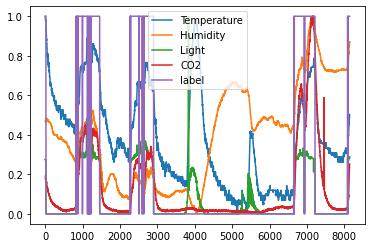

In [4]:
from sklearn.preprocessing import MinMaxScaler
print(trainset.shape)
#print(trainset.col())
X_train = trainset[["Temperature","Humidity","Light","CO2","HumidityRatio"]]
y_train = trainset["Occupancy"]
X_test = testset[["Temperature","Humidity","Light","CO2","HumidityRatio"]]
y_test = testset["Occupancy"]


# your code here
scaler=MinMaxScaler()
X_train_plot=X_train[["Temperature","Humidity","Light","CO2"]]
X_train_plot=MinMaxScaler().fit_transform(X_train_plot)
plt.plot(X_train_plot)
plt.plot(y_train)
plt.legend(labels=['Temperature','Humidity','Light','CO2','label'])


# 1) FFNN 구현
## 1-1) 데이터셋을 생성하시오

  - feature: ["Temperature", "Humidity", "Light", "CO2", "HumidityRatio"]
  - label: "Occupancy"

In [5]:
# feature 개수를 50개 늘린 효과 아래 함수 또한 코드 전체는 드리지 않습니다. 하지만 가장 어려운 부분을 드립니다.

def split_data(X, y, shift):
  X_split=[]
  y_split=[]
  for idx in range(shift, len(X)):
    X_split.append(X[idx-shift:idx])
    y_split.append([y[idx]])
  return np.array(X_split), np.array(y_split)
  

  

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



BATCH_SIZE = 1
EPOCHS = 5
SHIFT = 10
SHUFFLE_BUFFER_SIZE = 100


#X_train, y_train을 split_data 함수로 data shape을 바꾸시오.
X_train=scaler.fit_transform(X_train)
X_train_s,y_train_s=split_data(X_train,y_train,SHIFT)
X_test=scaler.transform(X_test)
y_test_s1=y_test.reset_index(drop=True)
X_test_s,y_test_s=split_data(X_test,y_test_s1,SHIFT)

print(X_train_s.shape)
print(y_train_s.shape)
print("\nsample X:\n", X_train_s[0],"\nsample y:\n", y_train_s[0])

(8133, 10, 5)
(8133, 1)

sample X:
 [[1.         0.47053302 0.27549041 0.190933   0.55731842]
 [0.99282297 0.47033188 0.27775383 0.18644592 0.55480723]
 [0.99282297 0.46932618 0.27549041 0.18613647 0.55376106]
 [0.99282297 0.46731478 0.27549041 0.1828872  0.55166876]
 [0.98086124 0.46731478 0.27549041 0.1805663  0.54785068]
 [0.98086124 0.46731478 0.27096357 0.17840012 0.54785068]
 [0.98086124 0.46731478 0.27096357 0.17881273 0.54785068]
 [0.98086124 0.46731478 0.27096357 0.17716231 0.54785068]
 [0.98086124 0.46731478 0.27096357 0.17117953 0.54785068]
 [0.97488038 0.46619734 0.27096357 0.17035432 0.54478846]] 
sample y:
 [1]


## 1-2) FFNN모델을 생성한 후, 학습 및 검증하여 성능을 확인하여라. 그리고 하이퍼 파라미터 튜닝 등을 통해 성능을 올려보시오. 


In [7]:
model_ffnn=keras.Sequential([
                        keras.layers.Flatten(input_shape=(10,5)),
                        keras.layers.Dense(64,activation='relu'),
                        keras.layers.Dense(32,activation='relu'),
                        keras.layers.Dense(16,activation='relu'),
                        keras.layers.Dense(8,activation='relu'),
                        keras.layers.Dense(1,activation='sigmoid')
])

model_ffnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                3264      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 6,017
Trainable params: 6,017
Non-trainable params: 0
______________________________________________________

FFNN model학습 hidden layer의 node수는 2의 배수로 많이 하는 경향(웹,교재)이있기에 위와같이 설정하였습니다

이하 Occupancy prediction 모델링에서는 **훈련데이터 : 6506 , 검증데이터 : 1627 ,  테스트데이터 : 2655** 로 진행

이진분류이기때문에 교재에 나온대로 손실함수로 '**binary_crossentropy**', FFNN 마지막 출력층에 '**sigmoid**' 활성화함수를 사용했습니다.
다양한 optimizer를 사용해봤지만 '**adam**' 가장 준수한 성능을 보여 과제내의 대부분의 모델에 adam optimizer를 사용하였습니다. 

In [8]:
model_ffnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_ffnn.fit(X_train_s,y_train_s,epochs=7,batch_size=BATCH_SIZE,validation_split=0.2,callbacks=[es,mc])

Epoch 1/7
6506/6506 [==============================] - 11s 2ms/step - loss: 0.0829 - accuracy: 0.9751 - val_loss: 0.2034 - val_accuracy: 0.9545
Epoch 2/7
6506/6506 [==============================] - 10s 2ms/step - loss: 0.0619 - accuracy: 0.9834 - val_loss: 0.4219 - val_accuracy: 0.9398
Epoch 3/7
6506/6506 [==============================] - 10s 2ms/step - loss: 0.0577 - accuracy: 0.9836 - val_loss: 0.1654 - val_accuracy: 0.9287
Epoch 4/7
6506/6506 [==============================] - 10s 1ms/step - loss: 0.0551 - accuracy: 0.9846 - val_loss: 0.2173 - val_accuracy: 0.9582
Epoch 5/7
6506/6506 [==============================] - 10s 2ms/step - loss: 0.0527 - accuracy: 0.9845 - val_loss: 0.5039 - val_accuracy: 0.9416
Epoch 6/7
6506/6506 [==============================] - 10s 2ms/step - loss: 0.0522 - accuracy: 0.9845 - val_loss: 0.0928 - val_accuracy: 0.9736
Epoch 7/7
6506/6506 [==============================] - 10s 2ms/step - loss: 0.0498 - accuracy: 0.9856 - val_loss: 0.6717 - val_accuracy:

In [9]:
model_ffnn.evaluate(X_test_s,y_test_s,batch_size=BATCH_SIZE)

2655/2655 [==============================] - 2s 930us/step - loss: 0.1483 - accuracy: 0.9661


[0.14834089577198029, 0.9661017060279846]

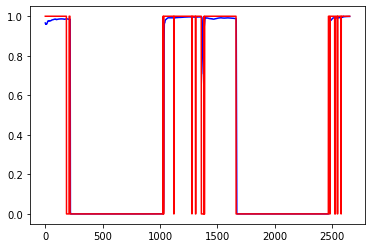

In [10]:
import matplotlib.pyplot as plt
y_predict = model_ffnn.predict(X_test_s)
# print(y_predict.shape)
# print(X_test_s.shape)
plt.plot(y_predict, 'blue')
plt.plot(y_test_s, 'red')


# 2) CNN 구현
# 2-1) MNIST 데이터셋을 읽어들이고 학습을 위한 데이터셋을 생성하시오

In [11]:
!ls sample_data
train_data_cnn = np.loadtxt('sample_data/mnist_train_small.csv', delimiter=',')
X_train_cnn = train_data_cnn[:, 1:].reshape(-1,28,28)/ 255
y_train_cnn = train_data_cnn[:, 0]

test_data_cnn = np.loadtxt('sample_data/mnist_test.csv', delimiter=',')
X_test_cnn = test_data_cnn[:, 1:].reshape(-1,28,28)/255
y_test_cnn = test_data_cnn[:, 0]



anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [12]:
# your code here
X_train_cnn_s=X_train_cnn.reshape((20000,28,28,1))
X_test_cnn_s=X_test_cnn.reshape((10000,28,28,1))


In [13]:
X_train_cnn_s.shape

(20000, 28, 28, 1)

# 2-2) 모델을 학습/ 평가 하시오

  - parameter/ structure를 바꿔가며 성능을 향상시키시오
  - 설마, 아래 출력된 모델 그대로 가시는 분 없겠죠? 모든 모델은 저와 달라야 합니다.

In [14]:
model_cnn=keras.Sequential()
model_cnn.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))
model_cnn.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))
model_cnn.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(64,activation='relu'))
model_cnn.add(keras.layers.Dense(10,activation='softmax'))
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)               

multi classification : loss func - sparse_categorical_crossentropy' 사용, 및 모델은 교재참고

In [15]:
model_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_cnn.fit(X_train_cnn_s,y_train_cnn,epochs=15,validation_split=0.15,callbacks=[es,mc])

Epoch 1/15
532/532 [==============================] - 17s 31ms/step - loss: 0.3049 - accuracy: 0.9058 - val_loss: 0.1551 - val_accuracy: 0.9517
Epoch 2/15
532/532 [==============================] - 16s 31ms/step - loss: 0.0795 - accuracy: 0.9745 - val_loss: 0.0678 - val_accuracy: 0.9773
Epoch 3/15
532/532 [==============================] - 16s 30ms/step - loss: 0.0508 - accuracy: 0.9848 - val_loss: 0.0708 - val_accuracy: 0.9787
Epoch 4/15
532/532 [==============================] - 16s 31ms/step - loss: 0.0400 - accuracy: 0.9878 - val_loss: 0.0602 - val_accuracy: 0.9823
Epoch 5/15
532/532 [==============================] - 16s 31ms/step - loss: 0.0298 - accuracy: 0.9899 - val_loss: 0.0551 - val_accuracy: 0.9840
Epoch 6/15
532/532 [==============================] - 16s 31ms/step - loss: 0.0251 - accuracy: 0.9915 - val_loss: 0.0577 - val_accuracy: 0.9857
Epoch 7/15
532/532 [==============================] - 17s 31ms/step - loss: 0.0179 - accuracy: 0.9938 - val_loss: 0.0628 - val_accuracy:

In [16]:
model_cnn.evaluate(X_test_cnn_s,y_test_cnn,verbose=2)

313/313 - 2s - loss: 0.0482 - accuracy: 0.9889


[0.04819174110889435, 0.9889000058174133]

# 3) RNN 구현
(CNN에서 사용했던 MNIST 데이터셋 사용 X)

이전에 FCNN에 사용했던 Occupancy 데이터셋에 RNN을 적용하고 FFNN과 성능을 비교하여라

## 3-1) 데이터셋을 생성하시오. 
  - 주어진 데이터셋을 가지고 1개 이상의 입력 시퀀스의 길이를 가진 timeseries데이터를 생성하시오
  - tf.data.Dataset.from_tensor_slices() 함수를 통해 텐서플로우 데이터셋을 생성하시오

In [17]:
trainset.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [ ]:
trainset

In [18]:
train_time_series = trainset.iloc[:6506,]
valid_time_series = trainset.iloc[6506:,]
train_time_series['date']=pd.to_datetime(train_time_series['date'])
train_time_series.reset_index(drop=True,inplace=True)
valid_time_series.reset_index(drop=True,inplace=True)
train_time_series.set_index('date',inplace=True)
valid_time_series.set_index('date',inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
scaler3=MinMaxScaler()
columns=['Temperature','Humidity','Light','CO2','HumidityRatio']
scaler3.fit(np.array(trainset[columns].to_numpy()))
train_time_series[columns]=scaler3.transform(np.array(train_time_series[columns]))
valid_time_series[columns]=scaler3.transform(np.array(valid_time_series[columns]))
train_time_series

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-04 17:51:00,1.000000,0.470533,0.275490,0.190933,0.557318,1
2015-02-04 17:51:59,0.992823,0.470332,0.277754,0.186446,0.554807,1
2015-02-04 17:53:00,0.992823,0.469326,0.275490,0.186136,0.553761,1
2015-02-04 17:54:00,0.992823,0.467315,0.275490,0.182887,0.551669,1
2015-02-04 17:55:00,0.980861,0.467315,0.275490,0.180566,0.547851,1
...,...,...,...,...,...,...
2015-02-09 06:11:59,0.119617,0.436026,0.000000,0.033576,0.272517,0
2015-02-09 06:13:00,0.119617,0.436026,0.000000,0.032028,0.272517,0
2015-02-09 06:14:00,0.119617,0.436026,0.000000,0.035432,0.272517,0


1번 FFNN에서 생성한 데이터셋이 이미 우리가 원하는 다변량 Timeseries데이터와 동일하므로 전처리는 여기까지만 진행하였습니다.

**텐서플로우 데이터셋 생성**


In [20]:
full_train_rnn=tf.data.Dataset.from_tensor_slices((X_train_s,y_train_s)).batch(1).prefetch(1)
train_rnn=full_train_rnn.take(6506) # 훈련데이터
valid_rnn=full_train_rnn.skip(6506) # 검증데이터 
test_rnn=tf.data.Dataset.from_tensor_slices((X_test_s,y_test_s)).batch(1).prefetch(1) # 테스트 데이터

## 3-2) 모델을 학습/ 평가 하시오

  - parameter/ structure를 바꿔가며 성능을 향상시키시오

In [21]:
model_rnn_A=keras.Sequential()
model_rnn_A.add(keras.layers.LSTM(64,activation='tanh',return_sequences=True,input_shape=(10,5)))
model_rnn_A.add(keras.layers.LSTM(32,activation='tanh',return_sequences=True))
model_rnn_A.add(keras.layers.LSTM(16,activation='tanh',return_sequences=True))
model_rnn_A.add(keras.layers.LSTM(8,activation='tanh',return_sequences=True))
model_rnn_A.add(keras.layers.TimeDistributed(keras.layers.Dense(1,activation='sigmoid')))
model_rnn_A.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 32)            12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            3136      
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 8)             800       
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 1)             9         
Total params: 34,281
Trainable params: 34,281
Non-trainable params: 0
_________________________________________________________________


In [23]:
model_rnn_A.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_rnn_A.fit(train_rnn,validation_data=valid_rnn,epochs=5,callbacks=[es,mc])

Epoch 1/5
6506/6506 [==============================] - 103s 15ms/step - loss: 0.2277 - accuracy: 0.9087 - val_loss: 2.2852 - val_accuracy: 0.6392
Epoch 2/5
6506/6506 [==============================] - 95s 15ms/step - loss: 0.2017 - accuracy: 0.9248 - val_loss: 2.1268 - val_accuracy: 0.6392
Epoch 3/5
6506/6506 [==============================] - 100s 15ms/step - loss: 0.1620 - accuracy: 0.9504 - val_loss: 2.1408 - val_accuracy: 0.6392
Epoch 4/5
6506/6506 [==============================] - 98s 15ms/step - loss: 0.1399 - accuracy: 0.9556 - val_loss: 2.2647 - val_accuracy: 0.6392
Epoch 5/5
6506/6506 [==============================] - 99s 15ms/step - loss: 0.1402 - accuracy: 0.9586 - val_loss: 2.2834 - val_accuracy: 0.6392


In [24]:
model_rnn_B=keras.Sequential()
model_rnn_B.add(keras.layers.LSTM(64,activation='tanh',return_sequences=True,input_shape=(10,5)))
model_rnn_B.add(keras.layers.LSTM(32,activation='tanh',return_sequences=True))
model_rnn_B.add(keras.layers.LSTM(16,activation='tanh',return_sequences=True))
model_rnn_B.add(keras.layers.LSTM(8,activation='tanh',return_sequences=True))
model_rnn_B.add(keras.layers.TimeDistributed(keras.layers.Dense(1,activation='sigmoid')))

In [25]:
model_rnn_B.compile(optimizer='adam',
              loss='binary_crossentro py',
              metrics=['accuracy'])
model_rnn_B.fit(X_train_s,y_train_s,validation_split=0.2,epochs=5,callbacks=[es,mc],batch_size=1)

Epoch 1/5
6506/6506 [==============================] - 73s 10ms/step - loss: 0.1235 - accuracy: 0.9652 - val_loss: 0.2418 - val_accuracy: 0.9265
Epoch 2/5
6506/6506 [==============================] - 68s 10ms/step - loss: 0.0794 - accuracy: 0.9787 - val_loss: 0.2990 - val_accuracy: 0.8942
Epoch 3/5
6506/6506 [==============================] - 67s 10ms/step - loss: 0.0807 - accuracy: 0.9777 - val_loss: 0.3155 - val_accuracy: 0.8921
Epoch 4/5
6506/6506 [==============================] - 67s 10ms/step - loss: 0.0833 - accuracy: 0.9764 - val_loss: 0.2479 - val_accuracy: 0.9238
Epoch 5/5
6506/6506 [==============================] - 69s 11ms/step - loss: 0.0791 - accuracy: 0.9785 - val_loss: 0.3338 - val_accuracy: 0.9326


In [26]:
model_rnn_A.evaluate(test_rnn)

2655/2655 [==============================] - 8s 3ms/step - loss: 2.2897 - accuracy: 0.6377


[2.289699077606201, 0.637664794921875]

In [27]:
model_rnn_B.evaluate(test_rnn)

2655/2655 [==============================] - 10s 3ms/step - loss: 0.1476 - accuracy: 0.9637


[0.1475534737110138, 0.9637287855148315]

동일한 형태의 RNN 모델(A,B) 생성 후  
model_A는 텐서플로우 데이터셋으로 변환한 데이터,
model_B는 기존 FFNN에서 사용한 array 데이터로 학습하였습니다
그런데 **분명 데이터형태의 차이일뿐 데이터값은 같은데 텐서플로우 데이터로 학습한 모델만 과적합(?)이 발생하여 모델이 성능을 내지못합니다.** (이후 문제 모델들에서도 그러함) 많은 시도를 해보았지만 까닭을 잘 모르겠습니다. 따라서 이후 모델링의 학습&검증은 array형식 데이터셋으로 진행하였습니다.  

테스트세트는 두 모델 모두 텐서플로우 데이터셋(test_rnn)사용

## 3-3 

Convolution 1D와 GRU (or LSTM)을 함께 사용해서 예측 성능을 평가하시오. 꼭 좋아질 필요가 없습니다. 다양한 모델을 경험하는 것이 이번 과제의 목표입니다. 

In [35]:
model_gru=keras.models.Sequential()
model_gru.add(keras.layers.Conv1D(filters=40,kernel_size=4,activation='relu',input_shape=(10,5)))
model_gru.add(keras.layers.GRU(20,activation='tanh',return_sequences=True))
model_gru.add(keras.layers.GRU(20,activation='tanh',return_sequences=True))
model_gru.add(keras.layers.TimeDistributed(keras.layers.Dense(1,activation='sigmoid')))
model_gru.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 7, 40)             840       
_________________________________________________________________
gru_4 (GRU)                  (None, 7, 20)             3720      
_________________________________________________________________
gru_5 (GRU)                  (None, 7, 20)             2520      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 7, 1)              21        
Total params: 7,101
Trainable params: 7,101
Non-trainable params: 0
_________________________________________________________________


conv1d & gru 모델의 layers 는 교재의 '1D 합성곱 층을 사용해 시퀸스 처리하기'를 참고하였습니다.

In [36]:
mc_gru=ModelCheckpoint('best_model.gru',monitor='val_loss',mode='min',save_best_only=True)
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gru.fit(X_train_s,y_train_s,epochs=5,validation_split=0.2,callbacks=[es,mc_gru],batch_size=1)

Epoch 1/5
6506/6506 [==============================] - 35s 5ms/step - loss: 0.0840 - accuracy: 0.9759 - val_loss: 0.3067 - val_accuracy: 0.9373


INFO:tensorflow:Assets written to: best_model.gru/assets


INFO:tensorflow:Assets written to: best_model.gru/assets


Epoch 2/5
6506/6506 [==============================] - 33s 5ms/step - loss: 0.0631 - accuracy: 0.9822 - val_loss: 0.2283 - val_accuracy: 0.9540


INFO:tensorflow:Assets written to: best_model.gru/assets


INFO:tensorflow:Assets written to: best_model.gru/assets


Epoch 3/5
6506/6506 [==============================] - 32s 5ms/step - loss: 0.0582 - accuracy: 0.9837 - val_loss: 0.3789 - val_accuracy: 0.9161
Epoch 4/5
6506/6506 [==============================] - 32s 5ms/step - loss: 0.0574 - accuracy: 0.9839 - val_loss: 0.0768 - val_accuracy: 0.9856


INFO:tensorflow:Assets written to: best_model.gru/assets


INFO:tensorflow:Assets written to: best_model.gru/assets


Epoch 5/5
6506/6506 [==============================] - 33s 5ms/step - loss: 0.0539 - accuracy: 0.9843 - val_loss: 0.8350 - val_accuracy: 0.7665


In [37]:
model_gru.evaluate(test_rnn)

2655/2655 [==============================] - 7s 2ms/step - loss: 0.1109 - accuracy: 0.9730


[0.1109158992767334, 0.9730427265167236]

## 3-4

ensemble 모델을 사용하시오. 
모델 3 or 4개를 만들어 각 모델의 결과를 평균내는 앙상블 모델을 사용하시오. 기본 모델은 FCNN으로 고정하고, 앙상블 모델 성능 평가하시오. 모델이 다 다를 필요 없음. 하나의 모델을 3~4개 만들어도 됩니다.


모델은 functional API로 구성할것.(Not Sequential)

참고자료:
https://www.tensorflow.org/guide/keras/functional


In [38]:
input1=keras.layers.Input(shape=(10,5))
x=keras.layers.Flatten()(input1)
x=keras.layers.Dense(64,activation='relu')(x)
x=keras.layers.Dense(32,activation='relu')(x)
x=keras.layers.Dense(16,activation='relu')(x)
x=keras.layers.Dense(8,activation='relu')(x)
out=keras.layers.Dense(1,activation='sigmoid')(x)
model1=keras.Model(inputs=input1,outputs=out)

In [39]:
input2=keras.layers.Input(shape=(10,5))
x=keras.layers.Flatten()(input2)
x=keras.layers.Dense(64,activation='relu')(x)
x=keras.layers.Dense(32,activation='relu')(x)
x=keras.layers.Dense(16,activation='relu')(x)
x=keras.layers.Dense(8,activation='relu')(x)
out=keras.layers.Dense(1,activation='sigmoid')(x)
model2=keras.Model(inputs=input2,outputs=out)

In [40]:
input3=keras.layers.Input(shape=(10,5))
x=keras.layers.Flatten()(input3)
x=keras.layers.Dense(64,activation='relu')(x)
x=keras.layers.Dense(32,activation='relu')(x)
x=keras.layers.Dense(16,activation='relu')(x)
x=keras.layers.Dense(8,activation='relu')(x)
out=keras.layers.Dense(1,activation='sigmoid')(x)
model3=keras.Model(inputs=input3,outputs=out)

In [41]:
input4=keras.layers.Input(shape=(10,5))
a=model1(input4)
b=model2(input4)
c=model3(input4)
k=keras.layers.average([a,b,c])
model_ensemble=keras.models.Model(input4,k)
model_ensemble.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 10, 5)]      0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 1)            6017        input_4[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 1)            6017        input_4[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 1)            6017        input_4[0][0]                    
____________________________________________________________________________________________

In [42]:
mc_ensemble=ModelCheckpoint('best_model.ensemble',monitor='val_loss',mode='min',save_best_only=True)
model_ensemble.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_ensemble.fit(X_train_s,y_train_s,validation_split=0.2,batch_size=1,epochs=5,callbacks=[es,mc_ensemble])

Epoch 1/5
6506/6506 [==============================] - 16s 2ms/step - loss: 0.1268 - accuracy: 0.9540 - val_loss: 0.2894 - val_accuracy: 0.9484
INFO:tensorflow:Assets written to: best_model.ensemble/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: best_model.ensemble/assets


Epoch 2/5
6506/6506 [==============================] - 15s 2ms/step - loss: 0.1050 - accuracy: 0.9691 - val_loss: 0.2677 - val_accuracy: 0.9478
INFO:tensorflow:Assets written to: best_model.ensemble/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: best_model.ensemble/assets


Epoch 3/5
6506/6506 [==============================] - 14s 2ms/step - loss: 0.1253 - accuracy: 0.9431 - val_loss: 0.2793 - val_accuracy: 0.9588
Epoch 4/5
6506/6506 [==============================] - 14s 2ms/step - loss: 0.0996 - accuracy: 0.9768 - val_loss: 0.2360 - val_accuracy: 0.9478
INFO:tensorflow:Assets written to: best_model.ensemble/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: best_model.ensemble/assets


Epoch 5/5
6506/6506 [==============================] - 15s 2ms/step - loss: 0.1240 - accuracy: 0.9358 - val_loss: 0.3709 - val_accuracy: 0.9428


In [43]:
model_ensemble.evaluate(test_rnn)

2655/2655 [==============================] - 4s 2ms/step - loss: 0.2339 - accuracy: 0.9292


[0.23385389149188995, 0.9291902184486389]

마지막 epochs에서의 모델 예측률이 높지않습니다. 

 *checkpoint로 val_loss 기준 가장 성능이 높았던 모델의 weight를 로드하여 다시 모델 평가를 진행했습니다.*

In [44]:
model_ensemble.load_weights('best_model.ensemble')
model_ensemble.evaluate(test_rnn)

2655/2655 [==============================] - 4s 1ms/step - loss: 0.2016 - accuracy: 0.9669


[0.2016238570213318, 0.966854989528656]

## 3-5
다중 입력 모델을 사용하시오.
이때 layer는  FCNN을 사용하시오.

Hands on ML 책에서 '함수형 API를 사용해 복잡한 모델 만들기(Wide & Deep)' 에서 보고 따라하시면 됩니다.

모델 성능 평가는 기본입니다.

input data set A는 "Temperature", "Humidity"

input data set B "Temperature", "Humidity", "Light", "CO2", "HumidityRatio"
로 하시오.

3)RNN 에서 생성한 타임시리즈 데이터 활용하여 전처리를 진행하였습니다. 
minmax 정규화가 적용된 데이터셋에서 컬럼을 추출하여 (A,B) 훈련,테스트 데이터셋 생성

In [89]:
test_time_series=testset
test_time_series[columns]=scaler3.transform(np.array(testset[columns]))
X_train_A = train_time_series[["Temperature","Humidity"]]
X_test_A = test_time_series[["Temperature","Humidity"]]
X_train_B = train_time_series[["Temperature","Humidity","Light","CO2","HumidityRatio"]]
X_test_B = test_time_series[["Temperature","Humidity","Light","CO2","HumidityRatio"]]

In [92]:
inputA=keras.layers.Input(shape=[2,])
inputB=keras.layers.Input(shape=[5,])

#x1=keras.layers.Flatten()(inputA)
x1=keras.layers.Dense(40)(inputA)
x1=keras.layers.Dense(20,activation='relu')(x1)
x1=keras.layers.Dense(20,activation='relu')(x1)
x1=keras.layers.Dense(10,activation='relu')(x1)

#x2=keras.layers.Flatten()(inputB)
x2=keras.layers.Dense(40)(inputB)
x2=keras.layers.Dense(20,activation='relu')(x2)
x2=keras.layers.Dense(20,activation='relu')(x2)
x2=keras.layers.Dense(10,activation='relu')(x2)

concat=keras.layers.concatenate([x1,x2])
output=keras.layers.Dense(1,activation='sigmoid')(concat)

model_wideep1=keras.models.Model(inputs=[inputA,inputB],outputs=[output])
model_wideep2=keras.models.Model(inputs=[inputA,inputB],outputs=[output])
model_wideep3=keras.models.Model(inputs=[inputA,inputB],outputs=[output])

In [93]:
m1=model_wideep1([inputA,inputB])
m2=model_wideep2([inputA,inputB])
m3=model_wideep3([inputA,inputB])

k=keras.layers.average([m1,m2,m3])
model_wideep=keras.models.Model(inputs=[inputA,inputB],outputs=k)
model_wideep.summary()

Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_44 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
model_33 (Functional)           (None, 1)            3281        input_43[0][0]                   
                                                                 input_44[0][0]                   
__________________________________________________________________________________________________
model_34 (Functional)           (None, 1)            3281        input_43[0][0]            

In [94]:
mc_wideep=ModelCheckpoint('best_model.wideep',monitor='val_loss',mode='min',save_best_only=True)
model_wideep.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_wideep.fit((X_train_A,X_train_B),y_train,validation_split=0.2,epochs=10,callbacks=[es,mc_wideep])

Epoch 1/10
163/163 [==============================] - 2s 5ms/step - loss: 0.3355 - accuracy: 0.8657 - val_loss: 0.0038 - val_accuracy: 1.0000
INFO:tensorflow:Assets written to: best_model.wideep/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: best_model.wideep/assets


Epoch 2/10
163/163 [==============================] - 0s 3ms/step - loss: 0.0746 - accuracy: 0.9806 - val_loss: 0.0010 - val_accuracy: 1.0000
INFO:tensorflow:Assets written to: best_model.wideep/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: best_model.wideep/assets


Epoch 3/10
163/163 [==============================] - 0s 3ms/step - loss: 0.0670 - accuracy: 0.9823 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 4/10
163/163 [==============================] - 0s 3ms/step - loss: 0.0653 - accuracy: 0.9831 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 5/10
163/163 [==============================] - 0s 3ms/step - loss: 0.0627 - accuracy: 0.9835 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 6/10
163/163 [==============================] - 0s 3ms/step - loss: 0.0603 - accuracy: 0.9837 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 7/10
163/163 [==============================] - 0s 3ms/step - loss: 0.0588 - accuracy: 0.9835 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 00007: early stopping


In [95]:
model_wideep.load_weights('best_model.wideep')
model_wideep.evaluate((X_test_A,X_test_B),y_test)

84/84 [==============================] - 0s 1ms/step - loss: 0.0788 - accuracy: 0.9782


[0.07881756871938705, 0.9782363772392273]